In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import netCDF4 as nc
import os
import scipy.io as sio
import scipy
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
from netCDF4 import Dataset
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
import sklearn.cluster as cluster
from sklearn.mixture import GMM
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.arange(180,350)
x_wcvi_slice = np.arange(480,650)


# bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

# Z = bathy.variables['Bathymetry'][:]

# lon = bathy['nav_lon'][...]
# lat = bathy['nav_lat'][...]


bathy = nc.Dataset('/data/ssahu/WCVI_sliced_bathy_NEP36_original.nc')


Z = bathy.variables['Bathymetry'][:]

# y_wcvi_slice = np.array(np.arange(180,350))
# x_wcvi_slice = np.array(np.arange(480,650))

# z_wcvi = Z[y_wcvi_slice, x_wcvi_slice]
lon_wcvi = bathy['nav_lon'][:]#[180:350, 480:650]
lat_wcvi = bathy['nav_lat'][:]#[180:350, 480:650]

z0 = np.ma.masked_values(Z, 0)

In [3]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

sal_mean_august  = np.mean(sal[88:119,...], axis=0)
temp_mean_august = np.mean(sal[88:119,...], axis=0)
spic_mean_august = np.mean(spic[88:119,...], axis=0)
rho_mean_august  = np.mean(rho[88:119,...], axis=0)

In [4]:
survey_mat_file_A = '/data/ssahu/Falkor_2013/mvp/surveyA.mat'
survey_mat_file_B = '/data/ssahu/Falkor_2013/mvp/surveyB.mat'
survey_mat_file_D = '/data/ssahu/Falkor_2013/mvp/surveyD.mat'
survey_mat_file_E = '/data/ssahu/Falkor_2013/mvp/surveyE.mat'
survey_mat_file_G = '/data/ssahu/Falkor_2013/mvp/surveyG.mat'


all_surveys = [survey_mat_file_A, survey_mat_file_B, survey_mat_file_D, \
              survey_mat_file_E, survey_mat_file_G]

lon_falkor = []
lat_falkor = []

for survey_file in all_surveys:
    
    mat = scipy.io.loadmat(survey_file)
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    
    lon_falkor = np.append(arr=lon_falkor, values=lon_survey)
    lat_falkor = np.append(arr=lat_falkor, values=lat_survey)
        

/home/ssahu/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


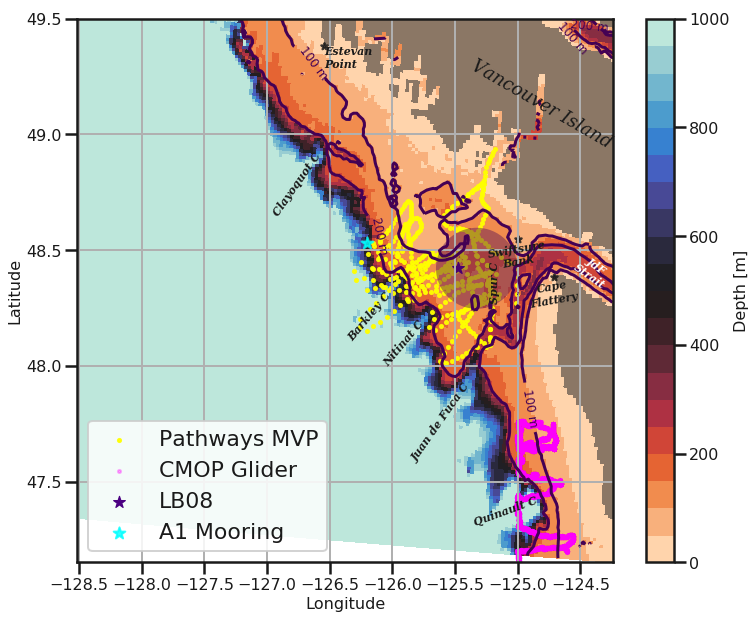

In [11]:
import matplotlib as mpl
# y = np.empty_like(lat_location)
# x = np.empty_like(lat_location)



cmap = plt.cm.get_cmap('icefire_r', 20)
# cmap = cmo.cm.turbid
# cmap = plt.cm.jet
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # force the first color entry to be grey
# cmaplist[0] = (.8, .8, .8, 1.0)

# # create the new map
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, cmap.N)
# cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(12,10)); ax.grid()

ax.set_aspect(viz_tools.set_aspect(ax, coords='map', lats=lat_wcvi, adjustable='box-forced'))


# ax.relim()
# ax.autoscale_view(True,True,True)
# ax.autoscale_view(scalex=True)
# ax.autoscale(enable=True, axis='both', tight=None)
# bathy_tools.plot_colourmesh(bathy, title = 'WCVI Subset', fig_size=(9, 9), axis_limits=None, colour_map='winter_r', bins=15, land_colour='burlywood')
# p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=500)


p = ax.pcolormesh(lon_wcvi,lat_wcvi,Z, cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(p, ax=ax)
ax.set_aspect('auto')



CS1 = ax.contour(lon_wcvi, lat_wcvi, Z, np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(lon_wcvi,lat_wcvi,Z, np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

# CS1 = ax.contour(lon_wcvi,lat_wcvi,Z, np.arange(1000,1010,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

# CS1 = ax.contour(lon_wcvi,lat_wcvi,Z, np.arange(500,510,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



# aspect = 20
# pad_fraction = 0.001
# divider = make_axes_locatable(ax)
# width = axes_size.AxesY(ax, aspect=1./aspect)
# pad = axes_size.Fraction(pad_fraction, width)
# cax = divider.append_axes("right", size=width, pad=pad)
# cbar = fig.colorbar(p, cax=cax)


# for i in np.arange(lat_location.shape[0]):
#     y[i], x[i] = geo_tools.find_closest_model_point(
#                lon_location[i],lat_location[i],lon_wcvi,lat_wcvi,tols={
#         'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
# n = np.empty_like(lat_location)
# m = np.empty_like(lat_location)


# for i in np.arange(lat_location.shape[0]):
#     n[i], m[i] = geo_tools.find_closest_model_point(
#                lon_location[i],lat_location[i],lon_wcvi,lat_wcvi,tols={
#         'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

# y = y.astype(int)
# x = x.astype(int)

# n = n.astype(int)
# m = m.astype(int)
# ax.scatter(x[:], y[:], c='orangered', s=100, alpha=0.5, label = 'Falkor CTD locations')

ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
# ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)

lon_W02 = -124.89500
lat_W02 = 48.04167

lon_W01 = -124.82500
lat_W01 = 48.31500



lon_swift = -125.00
lat_swift = 48.55

ax.scatter(lon_swift, lat_swift,  c='k', marker='*',  s=50, alpha=0.8)#, label = 'Swiftsure Bank')

# S = ("SwB")
S = ("Swiftsure\nBank")
ax.text(lon_swift, lat_swift, S, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='center', rotation = 10,
         va='top', wrap=False)
# ax.text(lon_swift, lat_swift, S, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 10,
#          va='bottom', wrap=False)


lat_cape = 48.3831
lon_cape = -124.7144

ax.scatter(lon_cape, lat_cape,  c='k', marker='*',  s=50, alpha=0.8)#, label = 'Cape Flattery')

CP = ("Cape\nFlattery")
ax.text(lon_cape, lat_cape, CP, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='center', rotation = 10,
         va='top', wrap=False)


lat_jdfs = 48.5
lon_jdfs = -124.4

JD = ("JdF\nStrait")
ax.text(lon_jdfs, lat_jdfs, JD, fontsize=11, color = 'white', fontweight = 'heavy',family='serif', style='italic', ha='center', rotation = -35,
         va='top', wrap=False)


lat_EP = 49.3835
lon_EP = -126.5447

ax.scatter(lon_EP, lat_EP,  c='k', marker='*',  s=50, alpha=0.8)

EP = ("Estevan\nPoint")
ax.text(lon_EP, lat_EP, EP, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 0,
         va='top', wrap=False)


lon_LB08 = -125.4775
lat_LB08 = 48.4217




ax.scatter(lon_falkor[::3], lat_falkor[::3],  c='yellow', marker='o',  s=10, alpha=0.9, label = 'Pathways MVP')

ax.scatter(lon_glider[::50], lat_glider[::50],  c='magenta', marker='o',  s=10, alpha=0.3, label = 'CMOP Glider')

ax.scatter(lon_LB08, lat_LB08,  c='indigo', marker='*',  s=150, linewidths=1.2, alpha=1, label = 'LB08')

lon_A1 = -126.20433
lat_A1 = 48.52958

ax.scatter(lon_A1, lat_A1,  c='cyan',marker='*',  s=150, alpha=0.8, label = 'A1 Mooring')

# ax.scatter(lon_W01, lat_W01, c='cyan', s=150, alpha=0.8, label = 'W01')

# ax.scatter(lon_W02, lat_W02, c='red', s=150, alpha=0.8, label = 'W02')

# ax.scatter(lon_location[:], lat_location[:], c='purple', s=100, alpha=0.3, label = 'Falkor CTD locations')

legend = ax.legend(loc='lower left', fancybox=True, framealpha=0.85)

# ax.set_xlabel('x_index')
# ax.set_ylabel('y_index')
# ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)

# viz_tools.plot_land_mask(ax, bathy)#, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
# cbar = fig.colorbar(p, cax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=16)
ax.tick_params(axis='both',labelsize =16)
cbar.ax.tick_params(labelsize=16) 

# t = ("JdF Canyon")
# ax.text(lon_W01, lat_W01, t, fontsize=11, color = 'darkblue', family='serif', style='italic', ha='left', rotation = 55,
#          va='bottom', wrap=True)

t = ("Juan de Fuca C")
ax.text(-125.79, 47.58, t, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 55,
         va='bottom', wrap=True)



d = ("Clayoquot C")
ax.text( -126.9, 48.64, d, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='left', rotation = 55,
         va='bottom', wrap=True)

C = ("Spur C")
ax.text(-125.14, 48.45, C, fontsize=11, color = 'k',fontweight = 'heavy', family='serif', style='italic', ha='right', rotation = 90,
         va='bottom', wrap=True)

X = ("Barkley C")
ax.text(-126.0, 48.3, X, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='right', rotation = 50,
         va='bottom', wrap=True)

Y = ("Nitinat C")
ax.text(-125.73, 48.18, Y, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='right', rotation = 50,
         va='bottom', wrap=True)


A = ("Quinault C")
ax.text(-124.83, 47.4, A, fontsize=11, color = 'k', fontweight = 'heavy',family='serif', style='italic', ha='right', rotation = 20,
         va='bottom', wrap=True)


V = ("Vancouver Island")
ax.text(-124.85, 49.1, V, fontsize=18, color = 'k', family='serif', style='italic', ha='center', rotation = -30,
         va='bottom', wrap=True)

from matplotlib.patches import Circle,Ellipse
from matplotlib.collections import PatchCollection


patches = []
# circle = Circle((lon_LB08, lat_LB08), 0.35)
# circle = plt.Circle((lon_LB08, lat_LB08), 0.2, color='blue')
circle = Ellipse((lon_LB08+0.15, lat_LB08), 0.65, 0.35,
                     angle=0, linewidth=2, fill=False, zorder=2, label = 'Eddy Region')
patches.append(circle)
colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)

ax.grid()






ax.set_ylim(top=49.5, bottom=47.15136337)
ax.set_xlim(left=-128.51552, right=-124.24068451)

path_to_save = '/home/ssahu/saurav/NEP36_Model_Eval_plots/'
# plt.savefig(path_to_save + 'Domain_edited.png')

In [5]:
# glider_data = pd.read_table('/data/ssahu/CMOP_glider_data/phoebe-2013-7-15_0002013-8-7_2359.csv', \
#                              delim_whitespace=1, parse_dates= True, header = None, skiprows=1)

glider_data = pd.read_table('/data/ssahu/CMOP_glider_data/phoebe-2013-5-8_0002013-6-1_2359.csv', \
                             delim_whitespace=1, parse_dates= True, header = None, skiprows=1)

In [6]:
df_cut = glider_data
columns = ['Time[PST]', 'Oxygen[ml/l]', 'Fluorescence[ug/l]', 'Salinity[PSU]', \
           'Longitude[degree_east]', 'Depth[m]', 'Latitude[degree_north]', 'CDOM[QSDE]', \
           'Backscatter[m^-1 sr^-1]', 'Temperature[C]']
# effective = columns[:7]
df_cut.columns = columns

for i in df_cut.select_dtypes([np.object]).columns[:]:
    
    df_cut[i] = df_cut[i].str.replace(',', '')
    
for i in df_cut.select_dtypes([np.object]).columns[1:]:
    
    df_cut[i] = df_cut[i].str.replace(',', '').astype(np.float)
    
    
df = pd.DataFrame()

df['Time[PST]']              = pd.to_datetime(df_cut.iloc[:,0])
df['Depth[m]']               = df_cut.iloc[:,5]
df['Latitude[degree_north]'] = df_cut.iloc[:,6]
df['Longitude[degree_east]'] = df_cut.iloc[:,4]
df['Temperature[C]']         = df_cut.iloc[:,-1]
df['Salinity[PSU]']          = df_cut.iloc[:,3]

# df = df.set_index('Time[PST]').groupby(pd.Grouper(freq='d')).mean().dropna(how='all')


# df = df.groupby(['Depth[m]']).mean().dropna()

# print(df.groupby(['Latitude[degree_north]', 'Longitude[degree_east]']).groups)



In [7]:
df.head(5)

,Time[PST],Depth[m],Latitude[degree_north],Longitude[degree_east],Temperature[C],Salinity[PSU]
0,2013-05-08 07:46:17,NaN,46.581,-123.946,0.0,NaN
1,2013-05-08 07:51:26,0.0,46.905,-124.106,NaN,NaN
2,2013-05-08 07:51:27,0.0,46.905,-124.106,NaN,NaN
3,2013-05-08 07:51:28,0.0,46.905,-124.106,NaN,NaN
4,2013-05-08 07:51:29,0.0,46.905,-124.106,NaN,NaN


In [8]:
df.shape[0]

758067

In [9]:
lon_glider = df['Longitude[degree_east]']
lat_glider = df['Latitude[degree_north]']


temp_glider = df['Temperature[C]']
sal_glider  = df['Salinity[PSU]']
depth_glider = df['Depth[m]']

pressure_loc = np.empty_like(lon_glider)
SA_loc       = np.empty_like(pressure_loc)
CT_loc       = np.empty_like(pressure_loc)
spic_loc     = np.empty_like(pressure_loc)
rho_loc      = np.empty_like(pressure_loc)

for i in np.arange(df.shape[0]):
    
    depth_loc = depth_glider[i]
    
    pressure_loc[i] = gsw.p_from_z(-depth_loc, lat_glider[i])

    SA_loc[i] = gsw.SA_from_SP(sal_glider[i], pressure_loc[i], lon_glider[i], lat_glider[i])

    CT_loc[i] = gsw.CT_from_pt(sal_glider[i], temp_glider[i])

    spic_loc[i] = gsw.spiciness0(SA_loc[i], CT_loc[i])

    rho_loc[i] = gsw.density.rho(SA_loc[i], CT_loc[i], 0)
 

In [10]:
   
    
df['Potential Density'] = rho_loc
    
df['Spice']             = spic_loc
    

In [11]:
dg  = df.groupby(['Latitude[degree_north]', 'Longitude[degree_east]', 'Depth[m]']).mean().dropna()

In [12]:
dg.head(20)

Temperature[C]  \
Latitude[degree_north] Longitude[degree_east] Depth[m]                   
46.905                 -124.106               0.000           15.73736   
46.908                 -124.740               3.773           10.83700   
                                              3.792           10.83700   
                                              3.841           10.83600   
                                              3.882           10.83800   
                                              3.922           10.83600   
                                              3.943           10.83800   
                                              4.021           10.83600   
                                              4.339           10.83800   
                                              4.516           10.83900   
                                              4.843           10.83900   
                                              5.000           10.83900   
                                              5.144           10.83900   
                                              5.435           10.84200   
                                              5.720           10.84100   
                                              5.895           10.83900   
                                              6.190           10.83600   
                                              6.329           10.83600   
                                              6.467           10.83600   
                                              6.738           10.83800   

                                                        Salinity[PSU]  \
Latitude[degree_north] Longitude[degree_east] Depth[m]                  
46.905                 -124.106               0.000             0.000   
46.908                 -124.740               3.773            31.228   
                                              3.792            31.228   
                                              3.841            31.229   
                                              3.882            31.228   
                                              3.922            31.229   
                                              3.943            31.228   
                                              4.021            31.229   
                                              4.339            31.228   
                                              4.516            31.228   
                                              4.843            31.228   
                                              5.000            31.227   
                                              5.144            31.227   
                                              5.435            31.227   
                                              5.720            31.227   
                                              5.895            31.227   
                                              6.190            31.228   
                                              6.329            31.227   
                                              6.467            31.227   
                                              6.738            31.227   

                                                        Potential Density  \
Latitude[degree_north] Longitude[degree_east] Depth[m]                      
46.905                 -124.106               0.000            998.986029   
46.908                 -124.740               3.773           1023.872481   
                                              3.792           1023.872481   
                                              3.841           1023.873429   
                                              3.882           1023.872308   
                                              3.922           1023.873428   
                                              3.943           1023.872307   
                                              4.021           1023.873426   
                                              4.33

In [61]:


#dg.to_csv('/data/ssahu/CMOP_glider_data/glider_data_may.csv')

In [25]:
dg.index.names

FrozenList(['Latitude[degree_north]', 'Longitude[degree_east]', 'Depth[m]'])

In [99]:
dg.loc[dg.index[5000][0],dg.index[5000][1]].iloc[:,3]

Depth[m]
36.924   -1.020044
37.184   -1.021073
37.615   -1.019467
37.819   -1.021053
38.024   -1.021053
38.412   -1.021868
38.760   -1.022789
38.966   -1.022575
39.319   -1.021684
39.497   -1.018368
39.718   -1.018367
40.159   -1.012513
40.394   -1.008797
40.773   -1.005407
41.161   -1.003197
41.394   -1.002583
41.627   -1.002582
42.043   -1.001507
42.235   -0.998422
42.570   -0.995444
43.004   -0.986020
43.232   -0.976029
43.443   -0.976027
43.636   -0.969843
43.973   -0.968784
44.362   -0.971018
44.795   -0.973551
45.161   -0.973745
45.360   -0.974355
45.697   -0.974243
            ...   
55.784   -0.856657
55.863   -0.855215
55.955   -0.855934
56.057   -0.855212
56.161   -0.851758
56.220   -0.848306
56.338   -0.844701
56.419   -0.843410
56.523   -0.843409
56.727   -0.841395
56.862   -0.837221
56.936   -0.830165
57.067   -0.825422
57.133   -0.817229
57.199   -0.817228
57.350   -0.814646
57.443   -0.809904
57.623   -0.806450
57.814   -0.803868
57.907   -0.801136
57.984   -0.801134
58.

In [95]:
trial_deep

array([ 36.924,  37.184,  37.615,  37.819,  38.024,  38.412,  38.76 ,
        38.966,  39.319,  39.497,  39.718,  40.159,  40.394,  40.773,
        41.161,  41.394,  41.627,  42.043,  42.235,  42.57 ,  43.004,
        43.232,  43.443,  43.636,  43.973,  44.362,  44.795,  45.161,
        45.36 ,  45.697,  45.959,  46.236,  46.409,  46.559,  46.747,
        46.945,  47.118,  47.434,  47.633,  47.793,  47.941,  48.203,
        48.515,  48.696,  49.018,  49.129,  49.239,  49.451,  49.643,
        49.758,  50.082,  50.25 ,  50.419,  50.651,  50.766,  51.038,
        51.33 ,  51.476,  51.621,  51.897,  52.052,  52.313,  52.558,
        52.661,  52.762,  52.863,  53.096,  53.331,  53.566,  53.789,
        53.95 ,  54.244,  54.517,  54.78 ,  54.906,  55.019,  55.155,
        55.368,  55.686,  55.784,  55.863,  55.955,  56.057,  56.161,
        56.22 ,  56.338,  56.419,  56.523,  56.727,  56.862,  56.936,
        57.067,  57.133,  57.199,  57.35 ,  57.443,  57.623,  57.814,
        57.907,  57.

In [109]:
### Let us make the along-isopycnal spice for three rho 26.3, 26.4 and 26.5 for each of the locations

# dg.loc[46.908,-124.740]

lon_position = np.empty(dg.index.shape[0])
lat_position = np.empty_like(lon_position)

spic_rho_263 = np.empty_like(lat_position)
spic_rho_264 = np.empty_like(lat_position)
spic_rho_265 = np.empty_like(lat_position)

for k in np.arange(dg.index.shape[0]):


    lon_position[k] =  dg.index[k][1]
    lat_position[k] = dg.index[k][0]

    depth_position = np.array(dg.loc[dg.index[k][0],dg.index[k][1]].index)

    rho_position   = dg.loc[dg.index[k][0],dg.index[k][1]].iloc[:,2] -1000
    spic_position  = dg.loc[dg.index[k][0],dg.index[k][1]].iloc[:,3] 

    spic_rho_263[k] = np.interp(26.3, rho_position, spic_position)
    
    spic_rho_264[k] = np.interp(26.4, rho_position, spic_position)
    
    spic_rho_265[k] = np.interp(26.5, rho_position, spic_position)
    
    
    
    
    

In [112]:
np.save('/data/ssahu/CMOP_glider_data/spice_on_iso_263.npy', arr=spic_rho_263)

np.save('/data/ssahu/CMOP_glider_data/spice_on_iso_264.npy', arr=spic_rho_264)

np.save('/data/ssahu/CMOP_glider_data/spice_on_iso_265.npy', arr=spic_rho_265)



In [114]:
np.save('/data/ssahu/CMOP_glider_data/lat_location.npy', arr=lat_position)

np.save('/data/ssahu/CMOP_glider_data/lon_location.npy', arr=lon_position)

In [115]:
!ls '/data/ssahu/CMOP_glider_data/'

glider_data_may.csv		      phoebe-2013-7-15_0002013-8-7_2359.csv
lat_location.npy		      spice_on_iso_263.npy
lon_location.npy		      spice_on_iso_264.npy
phoebe-2013-5-8_0002013-6-1_2359.csv  spice_on_iso_265.npy


In [5]:
lon_location = np.load('/data/ssahu/CMOP_glider_data/lon_location.npy')
lat_location = np.load('/data/ssahu/CMOP_glider_data/lat_location.npy')

spic_rho_263 = np.load('/data/ssahu/CMOP_glider_data/spice_on_iso_263.npy')
spic_rho_264 = np.load('/data/ssahu/CMOP_glider_data/spice_on_iso_264.npy')
spic_rho_265 = np.load('/data/ssahu/CMOP_glider_data/spice_on_iso_265.npy')

In [6]:
iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...];#[:,:,40:100,110:]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [7]:
iso_spic.shape

(180, 7, 170, 170)

In [22]:
iso_spic_glider_data_mean_time = np.mean(iso_spic[8:33,...], axis=0)

model_rho_263 = iso_spic_glider_data_mean_time[3,...]
model_rho_264 = iso_spic_glider_data_mean_time[4,...]
model_rho_265 = iso_spic_glider_data_mean_time[5,...]

y = np.empty_like(lat_location)
x = np.empty_like(lat_location)

for i in np.arange(lon_location.shape[0]):
    
    y[i], x[i] = geo_tools.find_closest_model_point(
           lon_location[i],lat_location[i],lon_wcvi,lat_wcvi,tols={
    'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    



In [83]:
y_new = y[~(np.isnan(x) & np.isnan(x))]
x_new = x[~(np.isnan(x) & np.isnan(x))]

model_263 = model_rho_263[y_new.astype(int), x_new.astype(int)]
model_264 = model_rho_264[y_new.astype(int), x_new.astype(int)]
model_265 = model_rho_265[y_new.astype(int), x_new.astype(int)]

spic_rho_263_finite = spic_rho_263[~(np.isnan(y) & np.isnan(x))]
spic_rho_264_finite = spic_rho_264[~(np.isnan(y) & np.isnan(x))]
spic_rho_265_finite = spic_rho_265[~(np.isnan(y) & np.isnan(x))]

In [ ]:
spic_rho_263_finite_final = spic_rho_263_finite[spic_rho_263_finite>-10]
model_263                 = model_263[spic_rho_263_finite>-10]


spic_rho_263_final = spic_rho_263_finite_final[spic_rho_263_finite_final>-2]
model_263          = model_263[spic_rho_263_finite_final>-2]

In [67]:
sns.set()

In [71]:
sns.set_style('darkgrid')
sns.set_context('talk')

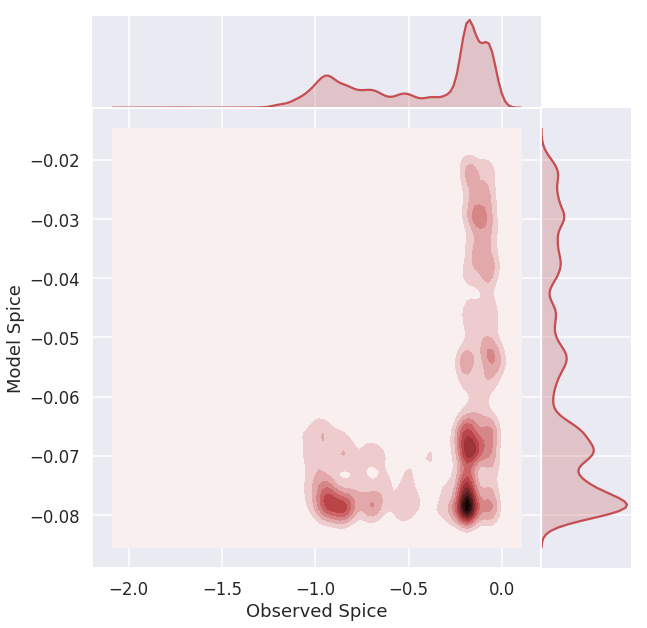

In [74]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = spic_rho_263_final
df['Model Spice'] = model_263


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

# sns.plt.ylim(0, 20)
# sns.plt.xlim(-1, 0)



fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [75]:
spic_rho_264_finite_final = spic_rho_264_finite[spic_rho_264_finite>-10]
model_264                 = model_264[spic_rho_264_finite>-10]


spic_rho_264_final = spic_rho_264_finite_final[spic_rho_264_finite_final>-2]
model_264          = model_264[spic_rho_264_finite_final>-2]

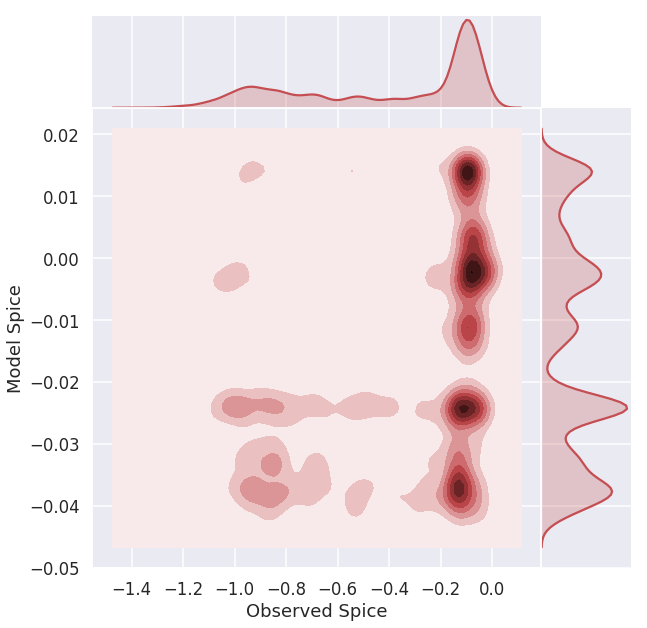

In [76]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = spic_rho_264_final
df['Model Spice'] = model_264


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

# sns.plt.ylim(0, 20)
# sns.plt.xlim(-1, 0)



fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [84]:
spic_rho_265_finite_final = spic_rho_265_finite[spic_rho_265_finite>-10]
model_265                 = model_265[spic_rho_265_finite>-10]


spic_rho_265_final = spic_rho_265_finite_final[spic_rho_265_finite_final>-2]
model_265          = model_265[spic_rho_265_finite_final>-2]

In [80]:

spic_rho_265_final_final = spic_rho_265_final[spic_rho_265_final>-0.2]
model_265          = model_265[spic_rho_265_final>-0.2]

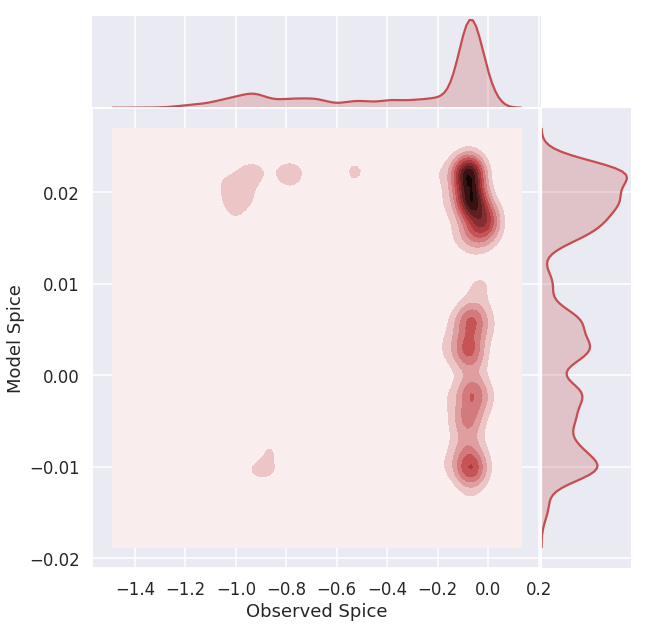

In [85]:



df =pd.DataFrame()

# df['Observed_Spice'] = survey_iso_spic_A
# df['Model_Spice'] = model_spic_A




df['Observed Spice'] = spic_rho_265_final
df['Model Spice'] = model_265


# fig, ax = plt.subplots(1,1, figsize=(10,8))

# q = df.plot.scatter(x="Observed_Spice", y="Model_Spice", ax = ax, alpha = 0.5)
# q = df.plot.hist2d(survey_iso_spic, model_spic, bins=(1, 1), cmap=plt.cm.Reds)
q = sns.jointplot(x="Observed Spice", y="Model Spice", data=df, legend='brief', kind="kde", space=0, color="r", sizes=(1,10), stat_func=None)
# gamma2,rms_error,ws = get_stat(df['Observed Spice'], df['Model Spice'])
# anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),prop=dict(size=14), loc=3, frameon=True,
#                        bbox_to_anchor=(1., 1.),
#                        bbox_transform=q.ax_joint.transAxes
#                        )
# q.ax_joint.add_artist(anchored_text)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.tick_params(axis='both',labelsize =16)

q.set_axis_labels('Observed Spice', 'Model Spice')

# sns.plt.ylim(0, 20)
# sns.plt.xlim(-1, 0)



fig = q.fig
fig.set_figwidth(10)
fig.set_figheight(10)




In [44]:
spic_rho_263.shape

(405285,)

In [57]:
model_263.shape

(279330,)

In [63]:
np.nanmean(model_263)

-0.059565421

In [66]:
np.min(spic_rho_263_finite_final)

-6.09829404291564

In [48]:
x_new.shape

(279330,)

In [32]:
y.shape

(405285,)

In [45]:
spic_rho_263_finite.shape

(279330,)

In [20]:
model_rho_264.shape

(170, 170)

In [21]:
lat_wcvi.shape

(170, 170)

In [11]:
f[:2]

[1, 2]

In [104]:
spic_position.shape

(146,)

In [105]:
lon_position

-124.762

In [40]:
trial  = np.array(dg.loc[46.908,-124.740].iloc[:,0])

In [42]:
trial


array([ 10.837,  10.837,  10.836,  10.838,  10.836,  10.838,  10.836,
        10.838,  10.839,  10.839,  10.839,  10.839,  10.842,  10.841,
        10.839,  10.836,  10.836,  10.836,  10.838,  10.839,  10.838,
        10.836,  10.836,  10.836,  10.836,  10.835,  10.837,  10.837,
        10.835,  10.834,  10.833,  10.835,  10.832,  10.821,  10.836,
        10.816,  10.811,  10.811,  10.82 ,  10.813,  10.795,  10.792,
        10.786,  10.786,  10.77 ,  10.75 ])

In [62]:
dg.index[:][0][0]

46.905000000000001

In [86]:
dg.index[405284][0]

47.761000000000003

In [87]:
dg.index[405284][1]

-124.95

In [70]:
dg.index.shape

(405285,)

In [ ]:
### Take the average of the model data for that month and then come up with the along iso-pycnal analysis